In [ ]:
] add DataFrames

In [1]:
using DrWatson
using Plots
using DataFrames
import PartitionedArraysBenchmarks as pb

In [2]:
path = mkpath("results")
cmd = :sbatch
function reduce_timing(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    # Discard first run
    t = maximum(iw->minimum(ir->ts[iw][ir],2:nruns),1:nworkers)
    t = minimum(ir->maximum(iw->ts[iw][ir],1:nworkers),2:nruns)
    #t = sum(iw->sum(ir->ts[iw][ir],2:nruns),1:nworkers)
    t
end
function max_worker_time(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    t = minimum(ir->maximum(iw->ts[iw][ir],1:nworkers),2:nruns)
    t
end
function min_worker_time(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    t = minimum(ir->minimum(iw->ts[iw][ir],1:nworkers),2:nruns)
    t
end
function total_worker_time(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    t = minimum(ir->sum(iw->ts[iw][ir],1:nworkers),2:nruns)
    t
end
filename = params -> joinpath(path,pb.jobname(params))
function parts_per_dir_array(P,D,m=prod(P))
    cis = CartesianIndices(P)
    a = filter(cis) do ci
        t = Tuple(ci)
        issorted(t) && maximum(t)-minimum(t)<=1 && prod(t) <= m
    end
    map(a) do a
        ntuple(D) do d
            if d > length(P)
                return 1
            end
            Int(a[d])
        end
    end
end
function optimal(x,y)
    x1 = x[1]
    y1 = y[1]
    C = y1/x1
    K = y1 - C / x1
    C ./ x .+ K
end
template = raw"""
#!/bin/bash
#SBATCH --time=00:45:00
#SBATCH --nodes={{{nodes}}}
#SBATCH --ntasks-per-node=24
#SBATCH --output={{{__JOBNAME__}}}.o
#SBATCH --error={{{__JOBNAME__}}}.e

export OMP_NUM_THREADS=1
export NUM_THREADS=1
mpiexec -np {{{np}}} --map-by node:span --rank-by core julia --project={{{__PROJECT__}}} -O3 --check-bounds=no -e '
   import PartitionedArraysBenchmarks as pb
   import PartitionedArrays as pa
   params = {{{__PARAMS__}}}
   jobname = "{{{__JOBNAME__}}}"
   pa.with_mpi() do distribute
       pb.experiment(pb.{{{benchmark}}},jobname,distribute,params)
   end
'
"""
function run_experiment(params;launch=true,force=false)
    if !launch
        fn = filename(params)
        if force || ! isfile(fn*".sh")
        @info "Would run $(fn)"
        end
        return
    end
    produce_or_load(params;filename,force,tag=false) do params
        pb.runjob(cmd,template,params;filename)
        Dict{String,Any}()
    end
end

run_experiment (generic function with 1 method)

In [26]:
cores_per_node = 24
cores_per_dir_3d = parts_per_dir_array((100,100,100),3,cores_per_node)
cores_per_dir_2d = parts_per_dir_array((100,100),3,cores_per_node)
cores_per_dir_1d = parts_per_dir_array((100,),3,cores_per_node)
nodes_in_cluster = 18
nodes_per_dir_3d = parts_per_dir_array((100,100,100),3,nodes_in_cluster)
nodes_per_dir_2d = parts_per_dir_array((100,100),3,nodes_in_cluster)
nodes_per_dir_1d = parts_per_dir_array((100,),3,nodes_in_cluster);
nodes_per_dir_3d

6-element Vector{Tuple{Int64, Int64, Int64}}:
 (1, 1, 1)
 (1, 1, 2)
 (1, 2, 2)
 (2, 2, 2)
 (2, 2, 3)
 (2, 3, 3)

## SpMV

In [29]:
methods_space = ["Petsc","PartitionedArrays"]
param_space = Dict(
    :nodes_per_dir => nodes_per_dir_3d[1:end],
    :cores_per_dir => cores_per_dir_3d[1:end],
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :nruns => 20,
    :sample => collect(1:1),
    :benchmark => :benchmark_spmv,
)
params = dict_list(param_space)
params = map(params) do dict
    dict[:parts_per_dir] = dict[:nodes_per_dir].*dict[:cores_per_dir]
    dict[:nodes] = prod(dict[:nodes_per_dir])
    dict[:np] = prod(dict[:parts_per_dir])
    dict
end;
for params in params
    run_experiment(params;launch=false)
end

In [35]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv_min] = min_worker_time.(df[!,:spmv])
df[!,:spmv_max] = max_worker_time.(df[!,:spmv])
df[!,:spmv_total] = total_worker_time.(df[!,:spmv])
sort!(df,[:method,:np,:sample])
df;

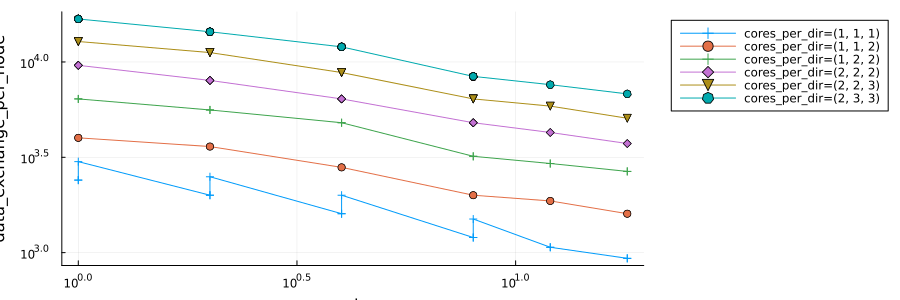

In [64]:
load_per_dir = map((a,b)->a./b,df[:,:cells_per_dir],df[:,:parts_per_dir])
interface_size = 2 .* sum.(load_per_dir)
data_exchange_per_node = interface_size .* df[!,:np] ./ df[!,:nodes]
df[!,:data_exchange_per_node] = data_exchange_per_node
nkey = :cores_per_dir
nvals = cores_per_dir_3d
xkey = :nodes
ykey = :data_exchange_per_node
plt = plot(size=(900,300),xlabel=xkey,ylabel=ykey)
for nval in nvals
        function take_row(row)
            bool = row[nkey] == nval
            bool
        end
        dh = filter(take_row,df)
        sort!(dh,[xkey,ykey])
        x = dh[:,xkey]
        y = dh[:,ykey]
        plot!(x,y,label="$nkey=$nval", markers=:auto,xaxis=:log,yaxis=:log,legend=:outertopright)
end
plt

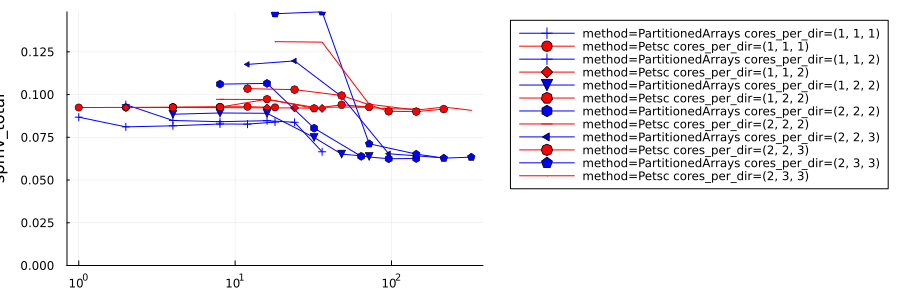

In [36]:
colors = [:blue,:red]
xkey = :np
ykey = :spmv_total
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"][1:end]
nkey = :cores_per_dir
nvals = cores_per_dir_3d
fixed = Dict(:cells_per_dir=>(400,400,400))
plt = plot(size=(900,300),xlabel=xkey,ylabel=ykey)
for nval in nvals
    for mval in mvals
        function take_row(row)
            bool = row[mkey] == mval && row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        dh = filter(take_row,df)
        sort!(dh,[vkey])
        if length(eachrow(dh)) != 0
           dg = groupby(dh,[xkey])
           dh = combine(dg) do sdf
              sdf[argmin(sdf[!,ykey]),:]
           end
        end
        sort!(dh,[xkey,ykey])
        x = dh[:,xkey]
        y = dh[:,ykey]
        plot!(x,y,label="$mkey=$mval $nkey=$nval",color=colors[findfirst(i->i==mval,mvals)], markers=:auto,xaxis=:log,ylimits=[0,Inf],legend=:outertopright)
    end
end
plt

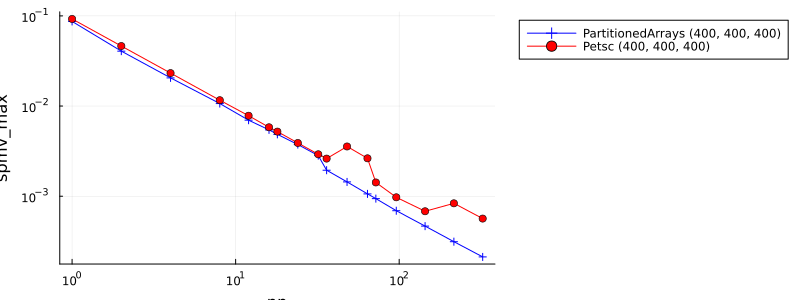

In [70]:
colors = [:blue,:red]
xkey = :np
ykey = :spmv_max
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"]
nkey = :cells_per_dir
nvals = [(400,400,400)]#,(500,500,500)]
fixed = Dict()
plt = plot(size=(800,300),xlabel=xkey,ylabel=ykey,xaxis=:log,yaxis=:log,legend=:outertopright)
for nval in nvals
    for mval in mvals
        function take_row(row)
            bool = row[mkey] == mval && row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        dh = filter(take_row,df)
        sort!(dh,[vkey])
        if length(eachrow(dh)) != 0
           dg = groupby(dh,[xkey])
           dh = combine(dg) do sdf
              sdf[argmin(sdf[!,ykey]),:]
           end
        end
        sort!(dh,[xkey,ykey])
        x = dh[:,xkey]
        y = dh[:,ykey]
        y2 = prod.(dh[:,:cells_per_dir])./dh[:,:np]
        plot!(x,y,label="$mval $nval",color=colors[findfirst(i->i==mval,mvals)], markers=:auto)
    end
end
plt

## SpMV

In [ ]:
methods_space = ["Petsc","PartitionedArrays"]
param_space = Dict(
    :nodes_per_dir => nodes_per_dir_3d[1:1],
    :cores_per_dir => cores_per_dir_3d[1:1],
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)
params = dict_list(param_space)
params = map(params) do dict
    dict[:parts_per_dir] = dict[:nodes_per_dir].*dict[:cores_per_dir]
    dict[:nodes] = prod(dict[:nodes_per_dir])
    dict[:np] = prod(dict[:parts_per_dir])
    dict
end;
for params in params
    run_experiment(params;launch=false)
end

In [ ]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv] = reduce_timing.(df[!,:spmv])
sort!(df,[:method,:np])
df;

In [ ]:
colors = [:blue,:red]
xkey = :np
ykey = :spmv
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"]
nkey = :cores_per_dir
nvals = cores_per_dir_3d
fixed = Dict(:cells_per_dir=>(400,400,400))
plt = plot(size=(600,300),xlabel=xkey,ylabel=ykey)
for nval in nvals
    for mval in mvals
        function take_row(row)
            bool = row[mkey] == mval && row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        df_filtered = filter(take_row,df)
        sort!(df_filtered,[vkey])
        x = df_filtered[:,xkey]
        y = df_filtered[:,ykey]
        plot!(x,y,label="$mval $nval",color=colors[findfirst(i->i==mval,mvals)], markers=:auto,xaxis=:log,yaxis=:log,legend=:outertopright)
    end
end
plt

In [ ]:
xkey = :np
ykey = :spmv
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"]
nkey = :cores_per_dir
nvals = cores_per_dir_3d
fixed = Dict(:cells_per_dir=>(400,400,400))
plt = plot(size=(600,350),xlabel=xkey,ylabel="$ykey ($(mvals[1])/$(mvals[2]))")
for nval in nvals    
        function take_row(row)
            bool = row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        df_filtered = filter(take_row,df)
        dg = groupby(df_filtered,vkey)
        dh = combine(dg) do sdf
           i1 = findfirst(sdf[!,mkey] .== mvals[1] )
           i2 = findfirst(sdf[!,mkey] .== mvals[2] )
           yval = sdf[i1,ykey]/sdf[i2,ykey]
           sdf[!,ykey] .= yval
           sdf[1,[vkey,xkey,ykey]]
        end
        sort!(dh,[vkey])
        x = dh[:,xkey]
        y = dh[:,ykey]
        plot!(x,y,label="$nkey = $nval",color=:blue, markers=:auto,xaxis=:log,ylimits=[0,Inf],legend=:outertopright)
end
xlms = xlims(plt)
plot!([xlms...],[1.,1.],label="tie",color=:black,xlimits=xlms)
plt

In [ ]:
cells_per_dir = (100,100,100)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

## SpMV old

In [ ]:
a = parts_per_dir_array((5,5,5),3,8)
map(i-> i=> prod(i),a)

In [ ]:
parts_per_dir_space = [(2,2,2)]
methods_space = ["Petsc"]
param_space = Dict(
    :nodes => 2,
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(100,100,100)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)
params = dict_list(param_space)
for params in params
    run_experiment(params;dryrun=false)
end

In [ ]:
#parts_per_dir_space = [(1,1,1)]#,(2,1,1),(3,1,1),(4,1,1),(5,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["PartitionedArrays","Petsc"]
param_space = Dict(
    :nodes => 2,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(600,600,600)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)

In [ ]:
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

In [ ]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv] = reduce_timing.(df[!,:spmv])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

In [ ]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["PartitionedArrays","Petsc"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:spmv]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,label=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

## Matrix assembly

In [ ]:
#parts_per_dir_space = [(1,1,1),(2,1,1),(3,1,1),(4,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["psprse","petsc_coo"]
param_space = Dict(
    :nodes => 1,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_psparse,
)
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

In [ ]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_psparse,dicts)
df = DataFrame(dicts)
df[!,:buildmat] = reduce_timing.(df[!,:buildmat])
df[!,:rebuildmat] = reduce_timing.(df[!,:rebuildmat])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

In [ ]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["psprse","petsc_coo"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:buildmat]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

In [ ]:
; squeue

In [ ]:
; ls results

In [ ]:
; cat results/060a76c710844502.sh

In [ ]:
?groupby

In [ ]:
df = DataFrame(a=repeat([1, 2, 3, 4], outer=[2]),
                      b=repeat([2, 1], outer=[4]),
                      c=1:8)

In [ ]:
gd = groupby(df, :a)